<h1>Projeto de Aprendizado de Máquina</h1>

### 2º semestre de 2022

#### Grupo formado por:
        Ana Clara Loponi - 220073
        Ana Clara Brandão - 220069
        Heitor Bernardes - 220052
        Lorraine Casseano - 220036
        
<h2>Dengue: O uso de ferramentas estatísticas para a propensão de uma das doenças mais negligenciadas do Brasil.</h2>
<h3>Usando Machine Learning para uma previsão de casos de Dengue em Campinas/SP</h3>

<ht> Entende-se que a Dengue é uma das doenças mais negligenciadas do Brasil, visto que, em todos os anos se observa um pico no número de casos confirmados. Observe que o padrão dos picos é referenciado com as características climáticas de épocas do ano. Com base nisso, é uma ideia de desenvolver um plano preventivo baseado nos dados testados.</ht>

<h2> Treinando Modelos II</h2>
<h3> Aprendizado não-supervisionado </h3>
<ht> Iniciando os processos de machine learning, foram treinados quatro diferentes modelos de aprendizado (PCA, k-Means, LOF, IF), juntamente com algumas análises dos respectivos modelos. </ht>

In [1]:
# Importação de bibliotecas
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.ensemble import IsolationForest

In [2]:
dados1 = pd.read_excel("dataset_dengue_categorico.xlsx")

#dados1

### Definir datasets de treino e teste, e hiperparâmetros gerais para todos os teste 

In [3]:
FEATURES = ["chuva", "temperatura-media", "temperatura-mininima", "temperatura-maxima", "meses"]
TARGET = ["cc"]
SEMENTE_ALEATORIA = 469

df = dados1

X = df.reindex(FEATURES, axis = 1) 

In [4]:
# Normalizador 
# Para esta tranformação, os dados precisam estar normalizados 

sc = StandardScaler() 
sc.fit(X)
X_norm = sc.transform(X)

### Transformação PCA 

In [5]:
# Transformação PCA
# Reduz a dimensionalidade das features
pca = PCA()
pca.fit(X_norm)
X_pca = pca.transform(X_norm)

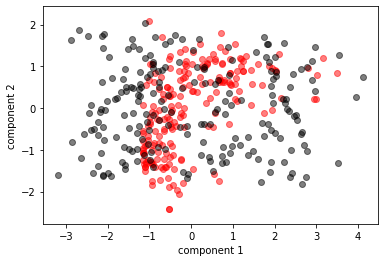

In [6]:
# Gráfico I 

plt.scatter(X_norm[:, 0], X_norm[:, 1], alpha=0.5, color="red")
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5, color="black")
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.axis('equal');

   
O gráfico apresenta uma solução bidemensional para os resultados do normalizador e da PCA, com as cores vermelho e preto. Em primeira análise, os dados foram espalhados maximizando a variância. Não há uma relação clara, utilizando somente essse gráfico.

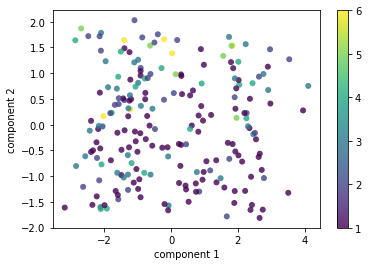

In [7]:
# Gráfico II: disperso, o padrão de cores corresponde aos classificadores

plt.scatter(X_pca[:, 0], X_pca[:, 1], edgecolor='none', alpha=0.8, c=df["cc"].values)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar()

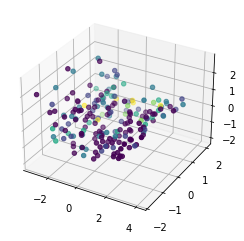

In [8]:
# Gráfico III: Versão 3D

from mpl_toolkits import mplot3d

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=df["cc"].values)

Esse novo gráfico agrupa os dados por cores, de roxo à amarelo, baseando-se nos classificadores. Contudo, não é possível perceber relação entre os grupos formados. Um dado roxo está completamente distante de outro roxo, e todos parecem espalhados, sobrepondo a área azul, por exemplo. Então, conclui-se que não ocorreu um agrupamento eficiente.

### Análise do peso das Features em relação com as componetes obtidas 

In [9]:
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca2 = X_pca
X_pca2 = pd.DataFrame(X_pca2, columns=component_names)
X_pca2.head()

loadings = pd.DataFrame(
    pca.components_.T,  # transpose the matrix of loadings
    columns=component_names,  # so the columns are the principal components
    index=X.columns,  # and the rows are the original features
)
loadings

,PC1,PC2,PC3,PC4,PC5
chuva,-0.383518,-0.083579,0.912664,0.111242,0.024443
temperatura-media,-0.561997,0.044293,-0.209641,-0.008770,-0.798856
temperatura-mininima,-0.522443,-0.041087,-0.145163,-0.731474,0.411386
temperatura-maxima,-0.513069,0.113141,-0.298112,0.665672,0.438144
meses,0.029773,0.988212,0.114681,-0.096824,0.004814


### Análise da variancia 

array([<AxesSubplot:title={'center':'Variancia explicada'}, xlabel='Componente'>,
       <AxesSubplot:title={'center':'Variância acumulada'}, xlabel='Componente'>],
      dtype=object)

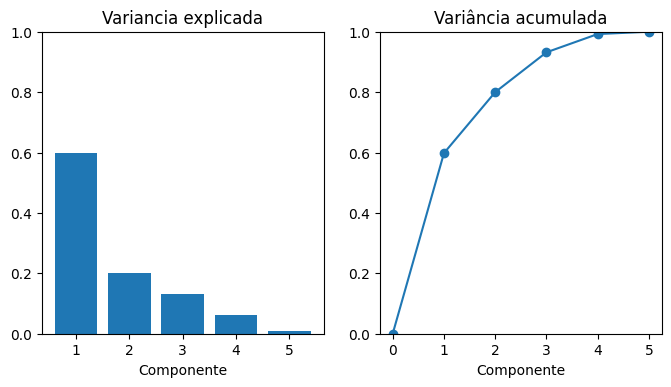

In [10]:
def plot_variance(pca, width=8, dpi=100):
    # Criar figura
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    
    # Fazer o cálculo da variância explicada
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Componente", 
        title="Variancia explicada", 
        ylim=(0.0, 1.0)
    )
    
    # Variância acumulada
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Componente", 
        title="Variância acumulada", 
        ylim=(0.0, 1.0)
    )
    
    # Detalhes da figura
    fig.set(figwidth=8, dpi=100)
    return axs

# Graficar
plot_variance(pca)

<p> Obseva-se que a componente1 tem relação significativa com dados referentes a temperatura. A componente2 tem relação alta apenas com a feature "meses", bem como a componete3 se relaciona com "chuva". </p>
<p> A análise de variancia mostra que a componente mais relevante é a primeira, seguida pelas segunda, terceira e quarta, respectivamente. Com base nos gráficos, foi possível concluir que a componente5 não contribui significativamente para o resultado. </p>  

In [11]:
# Normalizador 
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler() #Definindo o normalizador
X_norm = scaler.fit_transform(df[FEATURES].values) #Normalizando

df_scaled = pd.DataFrame(X_norm,columns = FEATURES) #Criando o DataFrame a partir com dados normalizados, que é um array de numpy
df_scaled = pd.concat([df_scaled,pd.Series(df['cc']).reset_index(drop=True)],axis=1) #Concatenando a coluna 'price' ao DataFrame
#print(df_scaled.head(10)) #Exibindo as 10 primeiras linhas do dataset normalizado

In [12]:
from sklearn.decomposition import PCA
import numpy as np

X = df_scaled[FEATURES] #Definindo o X como as features
y = df_scaled['cc']  #Definindo o y como o target

pca = PCA(n_components=4) #Calculando o PCA para três componentes
pca.fit(X)                #Ajustando o PCA
X_pca = pca.transform(X)  #Realizando o PCA

In [13]:
# Define Datasets de treino e teste
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( #Chamando a função train_test_split, atribuindo os valores nas variáveis a esquerda da igualdade
    X_pca,                                           #Dados das componentes principais do PCA
    y,                                               #Dados do target
    test_size=0.2,                                   #Tamanho do conjunto de teste
    random_state=42)                                 #Semente aleatória

In [14]:
# Modelo Arvore de Decisão

from sklearn.tree import DecisionTreeRegressor

modelo_dt = DecisionTreeRegressor(
    max_leaf_nodes=3,
    max_depth=None,
    random_state=SEMENTE_ALEATORIA
)
# treina o modelo
modelo_dt.fit(X_train, y_train)

DecisionTreeRegressor(max_leaf_nodes=3, random_state=469)

O RMSE do modelo árvore de decisão foi de 1.1608041590619989.


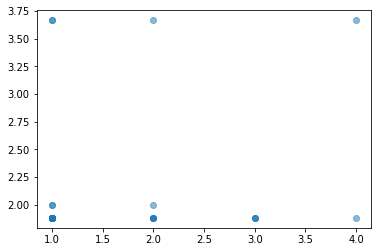

In [15]:
# RMSE
from sklearn.metrics import mean_squared_error

y_verdadeiro = y_test
y_previsao = modelo_dt.predict(X_test)

RMSE = mean_squared_error(y_verdadeiro, y_previsao)

plt.plot(y_verdadeiro, y_previsao, ls="none", marker="o", alpha=0.5)

print(f"O RMSE do modelo árvore de decisão foi de {RMSE}.")

O modelo treinado usando o método de PCA apresentou uma pequena melhora em relação aos anteriores.

### K-Means

In [16]:
# Agrupamento K-means 

n_clusters=3  #Define três clusters

kmeans = KMeans(            #Inicializando o K-Means
    n_clusters=n_clusters,  #Definindo número de clusters
    init='random',          #Inicialização randomica, aqui você pode tentar o K-Means++ :)
    n_init=10,              #Número de inicializações
    max_iter=300,           #Número máximo de iterações
    tol=1e-04,              #Tolerância para variação da coordenada dos centróides para definir a convergência
    random_state=0          #Define a semente aleatória
)

y_kmeans = kmeans.fit_predict(X_norm) #Fita o K-Means

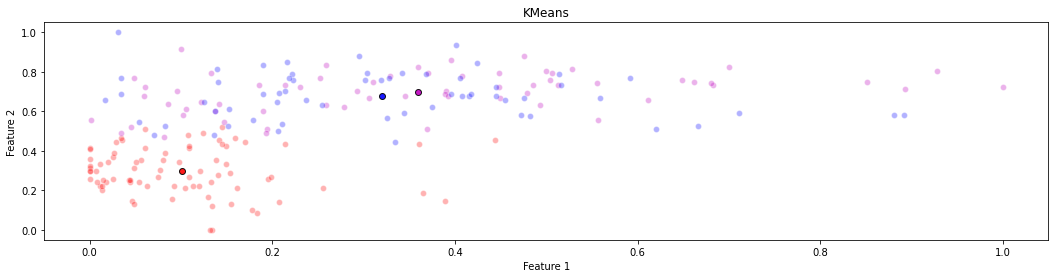

In [17]:
# Graficando 

centroids = kmeans.cluster_centers_ #Extraindo os centróides do K-Means
labels = pairwise_distances_argmin(X_norm, centroids) #Usando a função pairwise_distances_argmin 
                                                      #para dar os labels aos clusters
colors = ["r", "m", "b", "y", "k"] #Definindo a paleta de cores

fig = plt.figure(figsize=(18, 4)) #Definindo a figura e seu tamanho
ax = fig.add_subplot()             #Criando um subplot

for k, col in zip(range(n_clusters), colors): #Desempacotando a lista de número de cluster e cores.
    my_members = labels == k  #Define quais pontos são membros de cada cluster
    #print(my_members)        #Descomente essa linha para entender como se comporta a variável my_members
    cluster_center = centroids[k] #Pega as coordenadas do centróide k
    ax.plot(                      #Plota os pontos do centróide k
        X_norm[my_members, 0],    #Coordenada do eixo-x
        X_norm[my_members, 1],    #Coordenada do eixo-y
        markerfacecolor=col,      #Define a cor do ponto
        marker="o",               #Define o estilo do ponto
        markeredgecolor="w",      #Define a cor de contorno do ponto
        linewidth=0,               #Largura de linha zero, para não ligar os pontos
        alpha=0.3
    )
    ax.plot(                      #Plotando os centróides
        cluster_center[0],        #Coordenada x do centróide
        cluster_center[1],        #Coordenada y do centróide
        marker="o",               #Define estilo do ponto
        markerfacecolor=col,      #Define cor do ponto
        markeredgecolor="k",      #Define a cor do contorno do ponto
        markersize=6,             #Define o tamanho do ponto
        linewidth=0,               #Largura de linha zero, para não ligar os pontos
        alpha=0.9
    )

ax.set_title("KMeans")  #Título do gráfico
plt.xlabel('Feature 1') #Nome da componente x
plt.ylabel('Feature 2') #Nome da componente y

plt.show() #Mostrar o gráfico

O agrupamento não foi bom, os pontos estão muito espalhados e distante de seus repectivos centróides. Vamos repetir usando o PCA.

In [18]:
pca = PCA()
pca.fit(X_norm)
X_pca = pca.transform(X_norm)

y_kmeans = kmeans.fit_predict(X_pca)

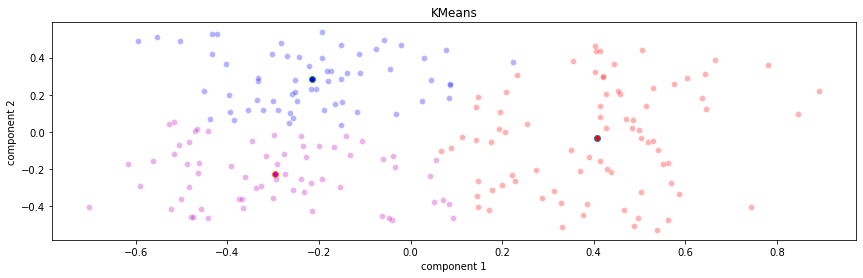

In [19]:
centroids = kmeans.cluster_centers_
labels = pairwise_distances_argmin(X_pca, centroids)
colors = ["r", "m", "b", "y", "k"]

fig = plt.figure(figsize=(14.4, 4))
ax = fig.add_subplot()

for k, col in zip(range(n_clusters), colors):
    my_members = labels == k
    cluster_center = centroids[k]
    ax.plot(
        X_pca[my_members, 0],
        X_pca[my_members, 1],
        "w", 
        markerfacecolor=col,
        marker="o",
        alpha = 0.3,
        linewidth=0)
    ax.plot(
        cluster_center[0],
        cluster_center[1],
        "o",
        markerfacecolor=col,
        markersize=6,
        alpha = 1.0,
        linewidth=0
    )

ax.set_title("KMeans")
plt.xlabel('component 1')
plt.ylabel('component 2')

plt.show()

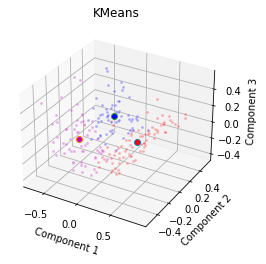

In [20]:
n_clusters=3

kmeans = KMeans(
    n_clusters=n_clusters, 
    init='random',
    n_init=10, 
    max_iter=300, 
    tol=1e-04, 
    random_state=0
)

y_kmeans = kmeans.fit_predict(X_pca)

centroids = kmeans.cluster_centers_
labels = pairwise_distances_argmin(X_pca, centroids)
colors = ["r", "m", "b", "y", "k"]

fig = plt.figure() #figsize=(22, 10))
ax = fig.add_subplot(projection='3d')

for k, col in zip(range(n_clusters), colors):
    my_members = labels == k
    cluster_center = centroids[k]
    ax.plot(
        X_pca[my_members, 0], 
        X_pca[my_members, 1],
        X_pca[my_members, 2],
        "w", 
        markerfacecolor=col, 
        marker=".",
        linewidth=0,
        alpha=0.3
    )
    ax.plot(
        cluster_center[0],
        cluster_center[1],
        cluster_center[2],
        "o",
        markerfacecolor=col,
        #markeredgecolor="k",
        markersize=6,
    )

ax.set_title("KMeans")
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')

plt.show()


<p>Aqui vemos um agrupamento melhor definido. </p>

<p> Abaixo, a dispersão dos grupos colorido de acordo os classificadores, veremos que essa feature não apresenta relação aparente
  com as cluesters.</p>

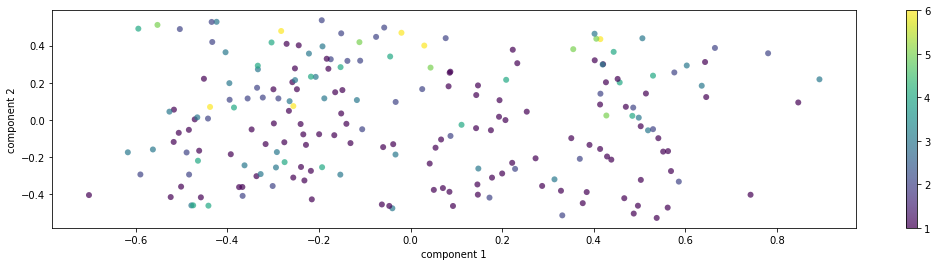

In [21]:
fig = plt.figure(figsize=(18, 4))
ax = fig.add_subplot()

plt.scatter(X_pca[:, 0], X_pca[:, 1], edgecolor='none', alpha=0.7, c=df["cc"].values)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar()
plt.show()

#### Within-Cluster-Sum of Squared Errors (WSS)

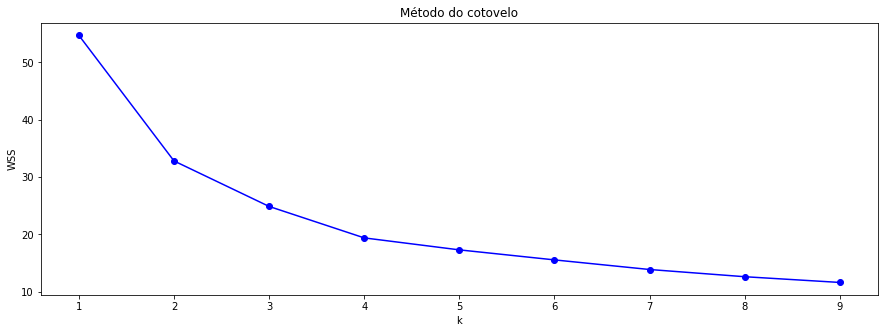

In [22]:
WSS = []  #Inicia uma lista vazia, para acumularmos valores.

for k in range(1,10): #Vamos fazer para 1 a 9 clusters.
    kmeans = KMeans(  #Inicializa o K-Means, como já explicado antes
        n_clusters=k, 
        init='random',
        n_init=10, 
        max_iter=300, 
        tol=1e-04, 
        random_state=0
    )
    y_kmeans = kmeans.fit_predict(X_pca) #Fita o K-Means
    WSS.append(kmeans.inertia_)          #Obtem a WSS e acumula na lista inicializada 
    
plt.figure(figsize=(15,5))              #Define o tamanho da figura
plt.plot(range(1,10), WSS, '-bo')        #Define o plot
plt.xlabel('k')                          #Nome da coordenada x
plt.ylabel('WSS')                        #Nome da coordenada y
plt.title('Método do cotovelo')          #Título do gráfico
plt.show()                               #Mostra o gráfico

Vimos que o cotovelo termina em k=4, portanto, vamos refazer o agrupamento com 4 cluesters.

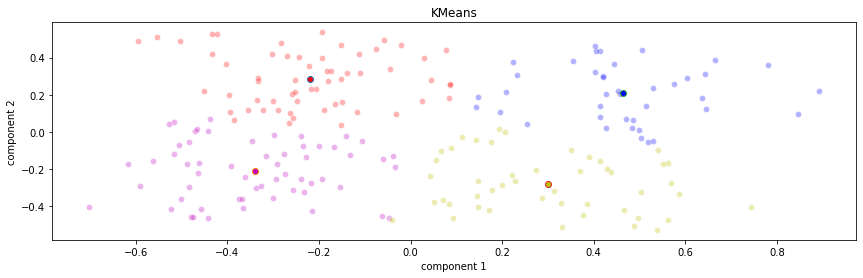

In [23]:
n_clusters=4  

kmeans = KMeans(            #Inicializando o K-Means
    n_clusters=n_clusters,  #Definindo número de clusters
    init='random',          #Inicialização randomica, aqui você pode tentar o K-Means++ :)
    n_init=10,              #Número de inicializações
    max_iter=300,           #Número máximo de iterações
    tol=1e-04,              #Tolerância para variação da coordenada dos centróides para definir a convergência
    random_state=0          #Define a semente aleatória
)

y_kmeans = kmeans.fit_predict(X_pca) #Fita o K-Means


centroids = kmeans.cluster_centers_
labels = pairwise_distances_argmin(X_pca, centroids)
colors = ["r", "m", "b", "y", "k"]

fig = plt.figure(figsize=(14.4, 4))
ax = fig.add_subplot()

for k, col in zip(range(n_clusters), colors):
    my_members = labels == k
    cluster_center = centroids[k]
    ax.plot(
        X_pca[my_members, 0],
        X_pca[my_members, 1],
        "w", 
        markerfacecolor=col,
        marker="o",
        alpha = 0.3,
        linewidth=0)
    ax.plot(
        cluster_center[0],
        cluster_center[1],
        "o",
        markerfacecolor=col,
        markersize=6,
        alpha = 1.0,
        linewidth=0
    )

ax.set_title("KMeans")
plt.xlabel('component 1')
plt.ylabel('component 2')

plt.show()

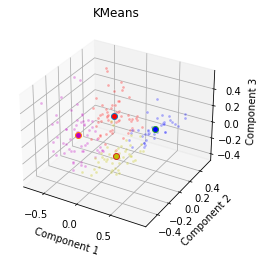

In [24]:
fig = plt.figure() 
ax = fig.add_subplot(projection='3d')

for k, col in zip(range(n_clusters), colors):
    my_members = labels == k
    cluster_center = centroids[k]
    ax.plot(
        X_pca[my_members, 0], 
        X_pca[my_members, 1],
        X_pca[my_members, 2],
        "w", 
        markerfacecolor=col, 
        marker=".",
        linewidth=0,
        alpha=0.3
    )
    ax.plot(
        cluster_center[0],
        cluster_center[1],
        cluster_center[2],
        "o",
        markerfacecolor=col,
        #markeredgecolor="k",
        markersize=6,
    )

ax.set_title("KMeans")
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')

plt.show()


### Algoritmo Local Outlier Factor (LOF)

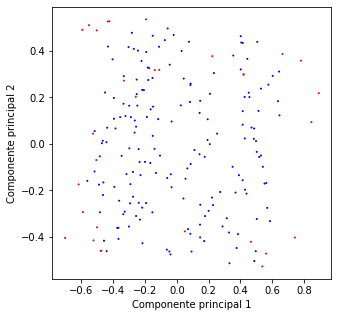

In [30]:
# precisamos indicar a fração de outliers, vamos estimar que seja 1%
FRACAO_OUTLIERS = 0.15

# precisamos também indicar o número de vizinhos que serão considerados
N_VIZINHOS = 50

CORES = np.array(["red", "blue"])

modelo_lof = LocalOutlierFactor(
    n_neighbors=N_VIZINHOS,
    contamination=FRACAO_OUTLIERS,
)

modelo_lof.fit(X_pca)
previsao = modelo_lof.fit_predict(X_pca)

fig, eixo = plt.subplots(figsize=(5, 5))

eixo.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    s=1,
    color=CORES[(previsao + 1) // 2],
)

eixo.set_xlabel("Componente principal 1")
eixo.set_ylabel("Componente principal 2")
plt.show()

### Algoritmo Isolation Forest (IF)

In [26]:
CORES = np.array(["red", "blue"])
COM_BORDA_DE_PREVISAO = True # mude para True para ver a borda de previsão

# aqui que criamos o modelo de Isolation Forest
modelo_if = IsolationForest(
    contamination=FRACAO_OUTLIERS,
    random_state=SEMENTE_ALEATORIA,
)

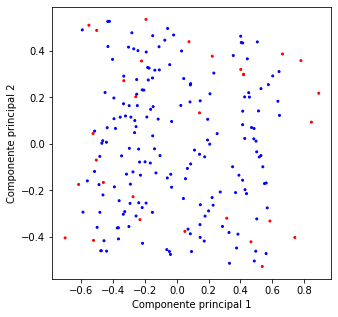

In [29]:
# precisamos indicar a fração de outliers, vamos estimar que seja 15%
FRACAO_OUTLIERS = 0.15

CORES = np.array(["red", "blue"])
COM_BORDA_DE_PREVISAO = True # mude para True para ver a borda de previsão

modelo_if = IsolationForest(
    contamination=FRACAO_OUTLIERS,
    random_state=SEMENTE_ALEATORIA,
)

# Ajustamos o modelo aos dados e realizamos a previsão
modelo_if.fit(X_pca)
previsao = modelo_if.predict(X_pca)

fig, eixo = plt.subplots(figsize=(5, 5))

eixo.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    s=4,
    color=CORES[(previsao + 1) // 2],
)

eixo.set_xlabel("Componente principal 1")
eixo.set_ylabel("Componente principal 2")
plt.show()

<ht> Observa-se que ambos os método tiveram resultados similares, e não muito conclusivos. Contudo, com as análise feitas até o momento, espera-se que valores anômalos sejam encontrados, uma vez que há grande variância em relação aos dados. </ht>